In [1]:
pip install control

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.6/549.6 kB 6.7 MB/s eta 0:00:00


In [2]:
import numpy as np
import torch
import torch.nn as nn
import control as ctrl
from control import NonlinearIOSystem
import matplotlib.pyplot as plt

In [4]:
# Считаем данные
p = np.loadtxt('out_1.txt')
p_ref = np.loadtxt('in_1.txt')

In [5]:
# Разделим на обучающие, валидационные и тестовые выборки
train_size = int(0.6 * len(p))  # 60% данных для обучения
val_size = int(0.2 * len(p))  # 20% для валидации
# оставшиеся 20% для тестирования

train_p, val_p, test_p = p[:train_size], p[train_size:train_size+val_size], p[train_size+val_size:]
train_p_ref, val_p_ref, test_p_ref = p_ref[:train_size], p_ref[train_size:train_size+val_size], p_ref[train_size+val_size:]


# Подготовим данные
def prepare_data(a, a_ref):
    X = []
    for i in range(2, len(a)):
        X.append([a[i], a[i-1], a_ref[i], a_ref[i-1]])
    return np.array(X)

X_train = prepare_data(train_p, train_p_ref)
X_val = prepare_data(val_p, val_p_ref)
X_test = prepare_data(test_p, test_p_ref)

In [6]:
# Выберем структуру нейронной сети
class SimpleNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.l_1 = nn.Linear(4, 64)
        self.a_1 = nn.ReLU()
        self.l_2 = nn.Linear(64, 64)
        self.a_2 = nn.ReLU()
        self.l_3 = nn.Linear(64, 1)

    def forward(self, x):
        x = self.l_1.forward(x)
        x = self.a_1.forward(x)
        x = self.l_2.forward(x)
        x = self.a_2.forward(x)
        x = self.l_3.forward(x)

        return x

In [8]:
# Обучим нейронную сеть
# Преобразуем данные в тензоры
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_train_tensor = torch.tensor(train_p[2:], dtype=torch.float32)
y_val_tensor = torch.tensor(val_p[2:], dtype=torch.float32)

# Создаем модель и оптимизатор
model = SimpleNN()
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)

epochs = 200
for epoch in range(epochs):
    model.train()

    # Обучение
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = loss_fn(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

    # Валидация
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val_tensor)
        val_loss = loss_fn(val_outputs, y_val_tensor)
        if (epoch + 1) % 10 == 0:
          print(f'Epoch [{epoch+1}/{epochs}], Validation Loss: {val_loss.item():.4f}')

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([4071])) that is different to the input size (torch.Size([4071, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1355])) that is different to the input size (torch.Size([1355, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [10/200], Loss: 0.6664
Epoch [10/200], Validation Loss: 0.6634
Epoch [20/200], Loss: 0.6666
Epoch [20/200], Validation Loss: 0.6642
Epoch [30/200], Loss: 0.6661
Epoch [30/200], Validation Loss: 0.6635
Epoch [40/200], Loss: 0.6661
Epoch [40/200], Validation Loss: 0.6634
Epoch [50/200], Loss: 0.6661
Epoch [50/200], Validation Loss: 0.6636
Epoch [60/200], Loss: 0.6661
Epoch [60/200], Validation Loss: 0.6635
Epoch [70/200], Loss: 0.6661
Epoch [70/200], Validation Loss: 0.6635
Epoch [80/200], Loss: 0.6661
Epoch [80/200], Validation Loss: 0.6635
Epoch [90/200], Loss: 0.6661
Epoch [90/200], Validation Loss: 0.6635
Epoch [100/200], Loss: 0.6661
Epoch [100/200], Validation Loss: 0.6635
Epoch [110/200], Loss: 0.6660
Epoch [110/200], Validation Loss: 0.6635
Epoch [120/200], Loss: 0.6660
Epoch [120/200], Validation Loss: 0.6635
Epoch [130/200], Loss: 0.6660
Epoch [130/200], Validation Loss: 0.6635
Epoch [140/200], Loss: 0.6660
Epoch [140/200], Validation Loss: 0.6635
Epoch [150/200], Loss: 0

In [33]:
# Создадим снейросетевую модель сервопривода
class NeuralNetModel:
    def __init__(self, model):
        self.model = model

    def update(self, x):
        return self.model(x)

neural_net_model = NeuralNetModel(model)
sys = NonlinearIOSystem(updfcn=neural_net_model.update)

In [36]:
# Проверим работу на тестовой выборке
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(test_p[2:], dtype=torch.float32)
outputs = []
for i in range(len(y_test_tensor)):
    outputs.append(sys._out(t=i, x=X_test_tensor[i], u=None)[-1])
outputs = torch.tensor(outputs, dtype=torch.float32)
test_loss = loss_fn(outputs, y_test_tensor)
print(f'Test Loss: {test_loss.item():.4f}')

Test Loss: 0.0136


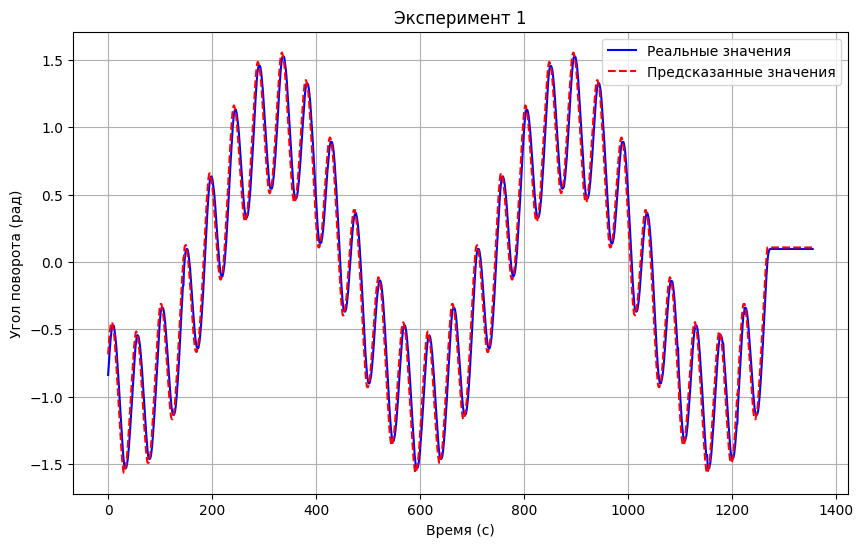

In [12]:
# Визуализируем результаты
plt.figure(figsize=(10, 6))
plt.plot(y_test_tensor, label="Реальные значения", color='blue')
plt.plot(outputs, label="Предсказанные значения", color='red', linestyle='--')
plt.xlabel('Время (с)')
plt.ylabel('Угол поворота (рад)')
plt.legend()
plt.title(f'Эксперимент 1')
plt.grid()
plt.show()

In [32]:
# Протестируем на других экспериментах
p2 = np.loadtxt('out_2.txt')
p2_ref = np.loadtxt('in_2.txt')
X2 = prepare_data(p2, p2_ref)
X2_tensor = torch.tensor(X2, dtype=torch.float32)
y2_tensor = torch.tensor(p2[2:], dtype=torch.float32)

outputs2 = []
for i in range(len(y2_tensor)):
    outputs2.append(sys._out(t=i, x=X2_tensor[i], u=None)[-1])
outputs2 = torch.tensor(outputs2, dtype=torch.float32)
test_loss = loss_fn(outputs2, y2_tensor)
print(f'Test Loss: {test_loss.item():.4f}')

Test Loss: 0.0065


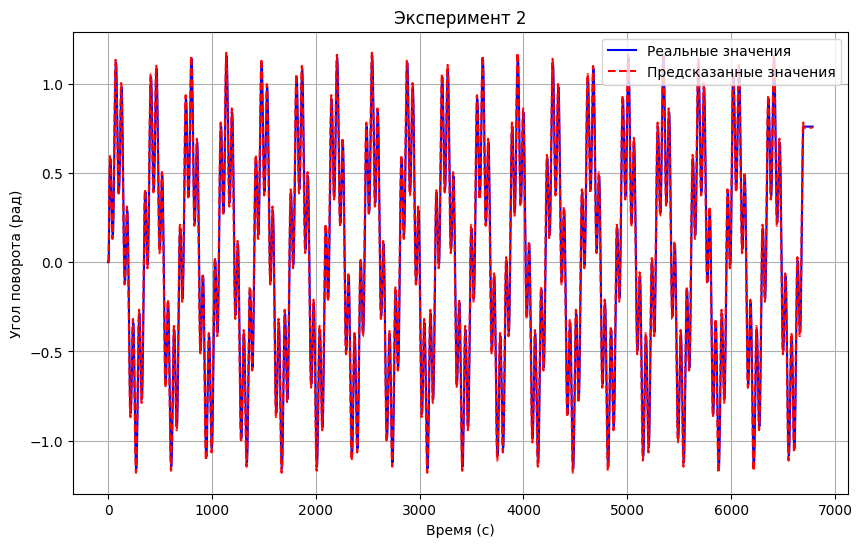

In [27]:
# Визуализируем результаты
plt.figure(figsize=(10, 6))
plt.plot(y2_tensor, label="Реальные значения", color='blue')
plt.plot(outputs2, label="Предсказанные значения", color='red', linestyle='--')
plt.xlabel('Время (с)')
plt.ylabel('Угол поворота (рад)')
plt.legend()
plt.title(f'Эксперимент 2')
plt.grid()
plt.show()

In [28]:
p3 = np.loadtxt('out_3.txt')
p3_ref = np.loadtxt('in_3.txt')
X3 = prepare_data(p3, p3_ref)
X3_tensor = torch.tensor(X3, dtype=torch.float32)
y3_tensor = torch.tensor(p3[2:], dtype=torch.float32)

outputs3 = []
for i in range(len(y3_tensor)):
    outputs3.append(sys._out(t=i, x=X3_tensor[i], u=None)[-1])
outputs3 = torch.tensor(outputs3, dtype=torch.float32)
test_loss = loss_fn(outputs3, y3_tensor)
print(f'Test Loss: {test_loss.item():.4f}')

Test Loss: 0.0322


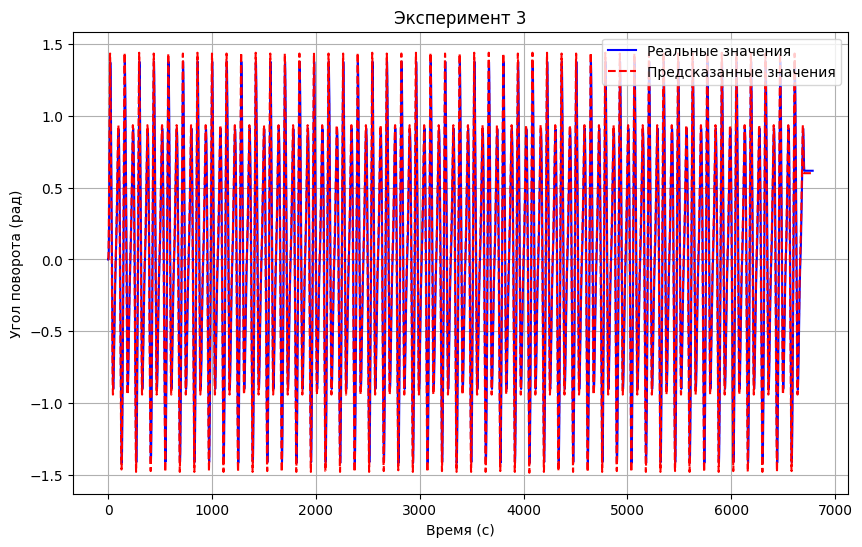

In [29]:
# Визуализируем результаты
plt.figure(figsize=(10, 6))
plt.plot(y3_tensor, label="Реальные значения", color='blue')
plt.plot(outputs3, label="Предсказанные значения", color='red', linestyle='--')
plt.xlabel('Время (с)')
plt.ylabel('Угол поворота (рад)')
plt.legend()
plt.title(f'Эксперимент 3')
plt.grid()
plt.show()

In [30]:
p4 = np.loadtxt('out_4.txt')
p4_ref = np.loadtxt('in_4.txt')
X4 = prepare_data(p4, p4_ref)
X4_tensor = torch.tensor(X4, dtype=torch.float32)
y4_tensor = torch.tensor(p4[2:], dtype=torch.float32)

outputs4 = []
for i in range(len(y4_tensor)):
    outputs4.append(sys._out(t=i, x=X4_tensor[i], u=None)[-1])
outputs4 = torch.tensor(outputs4, dtype=torch.float32)
test_loss = loss_fn(outputs4, y4_tensor)
print(f'Test Loss: {test_loss.item():.4f}')

Test Loss: 0.0039


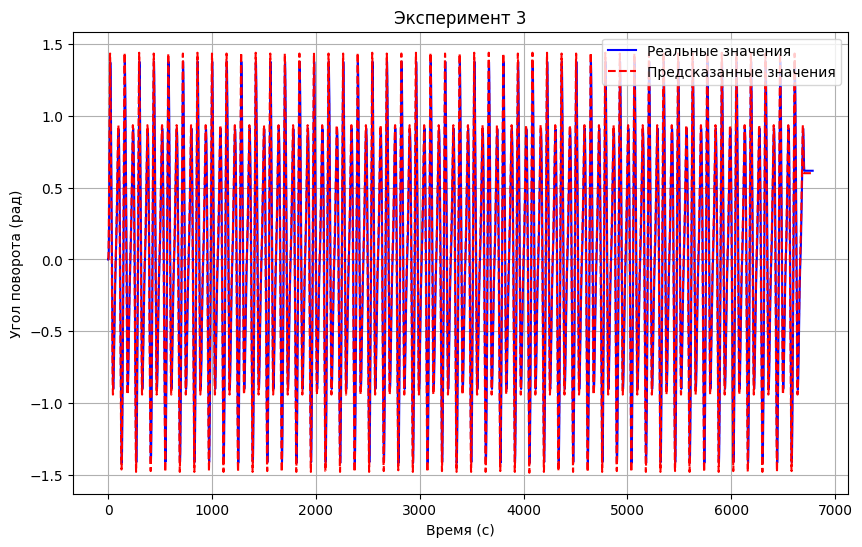

In [31]:
# Визуализируем результаты
plt.figure(figsize=(10, 6))
plt.plot(y3_tensor, label="Реальные значения", color='blue')
plt.plot(outputs3, label="Предсказанные значения", color='red', linestyle='--')
plt.xlabel('Время (с)')
plt.ylabel('Угол поворота (рад)')
plt.legend()
plt.title(f'Эксперимент 3')
plt.grid()
plt.show()